# Distribution and Moments of a Normalized Dissimilarity Ratio for two Correlated Gamma Variables

*Author: Elise Colin*  
*Title of the associated article: "Distribution and Moments of a Normalized Dissimilarity Ratio for two Correlated Gamma Variables
"*  

This notebook accompanies the article *"Distribution and Moments of a Normalized Dissimilarity Ratio for two Correlated Gamma Variables
"*. It provides the full numerical implementation used to validate the theoretical results presented in the paper.  
In particular, this notebook:
- Generates correlated Gamma-distributed random variables $X$ and $Y$ from correlated circular complex Gaussian fields.
- Computes empirical histograms of the Fujii index $D(X,Y) = \frac{|X - Y|}{X + Y}$.
- Compares empirical distributions and moments with the closed-form expressions derived in the article.
- Explores the effect of parameters such as the correlation coefficient $\rho$, the shape parameter $k$, and the variance $\sigma^2$.

This code is intended to facilitate reproducibility and further exploration of the statistical properties of the Fujii index, particularly in the context of dynamic speckle imaging.

## Empirical correlation between the Gamma-distributed intensities $X$ and $Y$ as a function of the input correlation $\rho$ of the complex fields.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_correlated_complex(N, rho, sigma, seed=None):
    """
    Generates two vectors of complex Gaussian variables (Zx, Zy)
    of size N, correlated such that Corr(Zx, Zy) = rho.

    Assumption: var(Re(Z)) = var(Im(Z)) = sigma**2
    Parameters
    -----------
    - N   : number of samples
    - rho: desired correlation (Pearson) between Zx and Zy
    - sigma: standard deviation of complex variables
    - seed: possibly an integer to fix the pseudorandom state

    Return:
    ---------
    (Zx, Zy) : two complex arrays numpy of size N
    """

    if seed is not None:
        np.random.seed(seed)

    Y1 = np.random.randn(N) * sigma  # real part
    Y2 = np.random.randn(N) * sigma  # imaginary part
    Zy = Y1 + 1j*Y2

    X1 = np.random.randn(N) * sigma
    X2 = np.random.randn(N) * sigma
    Zxx = X1 + 1j*X2

    Zx = rho * Zy + np.sqrt(1 - rho**2)*Zxx

    return Zx, Zy



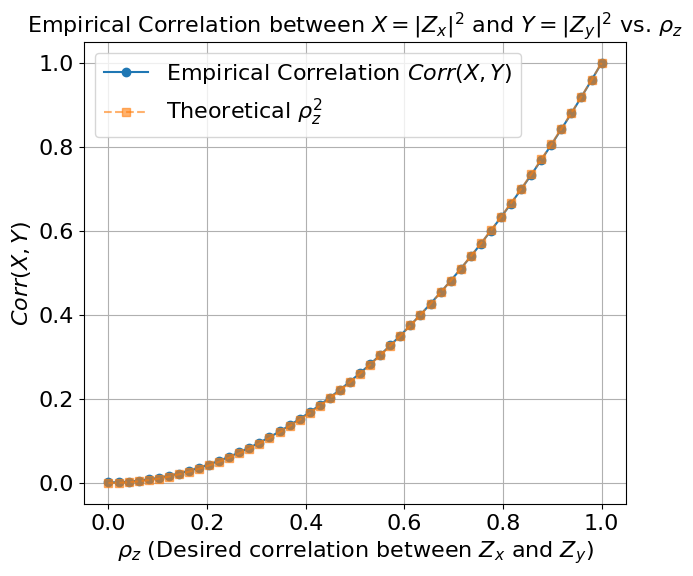

In [2]:
# ---------------------------
# Simulation Parameters
# ---------------------------
N = 100000     # Number of samples
rhos = np.linspace(0, 1, 50)  # Different values of rho (including negative values)
corr_empirique_list = []  # List to store empirical correlations
theorique_list = []       # List to store theoretical values
sigma = 1                 # Standard deviation for the Gaussian distribution
seed = 153                # Random seed for reproducibility

for rho in rhos:
    # 1) Generate correlated complex fields Zx and Zy
    Zx, Zy = generate_correlated_complex(N, rho, sigma, seed=seed)

    # 2) Compute intensities: Ix = |Zx|^2 and Iy = |Zy|^2
    Ix = np.abs(Zx)**2
    Iy = np.abs(Zy)**2

    # 3) Calculate empirical correlation
    corr_Ix_Iy = np.corrcoef(Ix, Iy)[0,1]

    # 4) Store results for plotting
    corr_empirique_list.append(corr_Ix_Iy)
    theorique_list.append(rho**2)

# ---------------------------
# Plotting Results
# ---------------------------
plt.figure(figsize=(7, 6))
plt.plot(rhos, corr_empirique_list, 'o-', label=r'Empirical Correlation $Corr(X,Y)$')
plt.plot(rhos, theorique_list, 's--', label=r'Theoretical $\rho_z^2$', alpha=0.6)
plt.xlabel(r'$\rho_z$ (Desired correlation between $Z_x$ and $Z_y$)', fontsize=16)
plt.ylabel(r'$Corr(X, Y)$', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.title(r'Empirical Correlation between $X=|Z_x|^2$ and $Y=|Z_y|^2$ vs. $\rho_z$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()



## Deriving the Joint PDF of Two Correlated Exponential Variables

In this section, we derive and validate the probability density function (PDF) of two correlated exponential random variables $X$ and $Y$. This derivation forms a crucial step in our overall framework, as it serves as the foundation for obtaining the joint PDF of correlated Gamma-distributed variables in subsequent sections.

The starting point of this derivation lies in the representation of $X$ and $Y$ as the squared magnitudes of two correlated circular complex Gaussian variables $Z_X$ and $Z_Y$. Leveraging the properties of these Gaussian fields, we obtain an analytical expression for the joint PDF of $(X, Y)$.

The derived PDF captures the statistical dependence between $X$ and $Y$ through the correlation coefficient $\rho$, which is directly linked to the correlation of the underlying complex fields. In this notebook, we implement the theoretical formula for the joint PDF and compare it to empirical histograms generated from numerical samples. The high degree of agreement between the empirical results and the theoretical PDF validates the correctness of our derivation.

This section also highlights how the correlation between exponential variables evolves as a function of $\rho$ and the variance parameter $ \sigma^2$. Understanding this relationship is essential for dynamic speckle analysis, where the intensities often follow exponential or Gamma distributions depending on the integration process and the number of independent speckles involved.



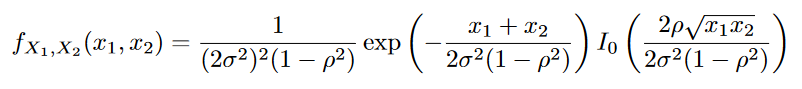

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0  # i0 = I_0 (Modified Bessel function of the first kind, order 0)

# --------- 2) Theoretical PDF of Ix and Iy ---------
def pdf_IxIy(x, y, rho, sigma):
    """
    Returns the joint PDF f_{Ix,Iy}(x,y) for x > 0 and y > 0,
    parameterized by rho (real-valued) and sigma.

    Formula:
    f_{Ix,Iy}(x, y) = [1 / ((2sigma^2)^2(1 - rho^2))]
                      * exp[-(x + y) / ((2sigma^2)(1 - rho^2))]
                      * I0( [2 rho * sqrt(xy)] / [(2sigma^2)(1 - rho^2)] )

    Parameters:
    x : float
        Intensity value for Ix (must be > 0).
    y : float
        Intensity value for Iy (must be > 0).
    rho : float
        Correlation coefficient (must satisfy |rho| < 1).
    sigma : float
        Standard deviation of the Gaussian field.

    Returns:
    float
        The value of the joint PDF at (x, y).
    """
    # Return 0 if x or y are non-positive (PDF is defined only for positive intensities)
    if (x <= 0) or (y <= 0):
        return 0.0

    # Compute the denominator involving sigma and rho
    denom = (1 - rho**2) * (2 * sigma**2)

    # Exponential term in the formula
    expo = np.exp(-(x + y) / denom)

    # Argument for the modified Bessel function I0
    arg_bessel = 2 * rho * np.sqrt(x * y) / denom

    # Final computation of the joint PDF
    return (1.0 / denom) * expo * i0(arg_bessel) / (2 * sigma**2)


In [4]:
# ---------  Simulation and 2D Histogram ---------
N = 1000000      # Number of samples
rho = 0.8       # Desired correlation
sigma = 0.7     # Standard deviation of the Gaussian fields
seed = 153       # Random seed for reproducibility

# Generate correlated complex fields
Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma, seed=seed)

# Compute intensities: Ix = |Zx|^2 and Iy = |Zy|^2
Ix = np.abs(Zx)**2
Iy = np.abs(Zy)**2

# Consistency checks
from IPython.display import display, Math
# Affichage propre des valeurs avec LaTeX
display(Math(r'\langle X \rangle = 2\sigma^2 \quad \rightarrow \quad \text{{Empirical: }} {:.4f}, \; \text{{Theoretical: }} {:.4f}'.format(np.mean(Ix), 2 * sigma**2)))
display(Math(r'\text{{Corr}}(X,Y) = \rho^2 \quad \rightarrow \quad \text{{Empirical: }} {:.4f}, \; \text{{Theoretical: }} {:.4f}'.format(np.corrcoef(Ix, Iy)[0,1], rho**2)))



# Empirical 2D Histogram
bins = 280  # Number of bins for the histogram grid

# Define axis limits for the histogram (adjust based on data)
max_val = 10 * (sigma**2)
range_xy = [[0, max_val], [0, max_val]]

# Compute 2D histogram with density normalization
H, xedges, yedges = np.histogram2d(Ix, Iy, bins=bins, range=range_xy, density=True)

# Compute bin centers for plotting
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Dx = np.max(xc)-np.min(xc)
Dy = np.max(yc)-np.min(yc)


# ---------  Theoretical PDF Grid ---------
XX, YY = np.meshgrid(xc, yc, indexing='xy')  # Generate 2D grid (bins x bins)
pdf_theo = np.vectorize(pdf_IxIy)(XX, YY, rho, sigma)



<IPython.core.display.Math object>

<IPython.core.display.Math object>

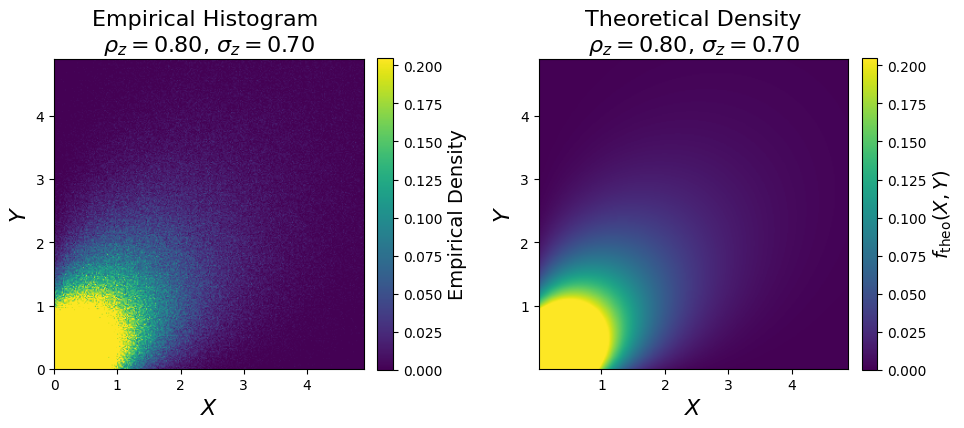

In [5]:
# ---------  Visualization and Comparison ---------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})  # Taille plus grande mais plots carrés

# A) Empirical: Heatmap of the histogram
im0 = axes[0].imshow(H.T, origin='lower',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='equal', cmap='viridis', vmin=0, vmax=1/(np.sqrt(Dx*Dy)))
axes[0].set_title(r"Empirical Histogram " "\n" r"$\rho_z = %.2f$, $\sigma_z = %.2f$" % (rho, sigma), fontsize=16)
axes[0].set_xlabel(r"$X$", fontsize=16)
axes[0].set_ylabel(r"$Y$", fontsize=16)
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label(r"Empirical Density", fontsize=14)

# B) Theoretical: Heatmap of the analytical PDF
im1 = axes[1].imshow(pdf_theo.T, origin='lower',
                     extent=[xc[0], xc[-1], yc[0], yc[-1]],
                     aspect='equal', cmap='viridis', vmin=0, vmax=1/(np.sqrt(Dx*Dy)))
axes[1].set_title(r"Theoretical Density" "\n" r"$\rho_z = %.2f$, $\sigma_z = %.2f$" % (rho, sigma), fontsize=16)
axes[1].set_xlabel(r"$X$", fontsize=16)
axes[1].set_ylabel(r"$Y$", fontsize=16)
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label(r"$f_{\text{theo}}(X, Y)$", fontsize=14)

plt.tight_layout(pad=2)
plt.show()



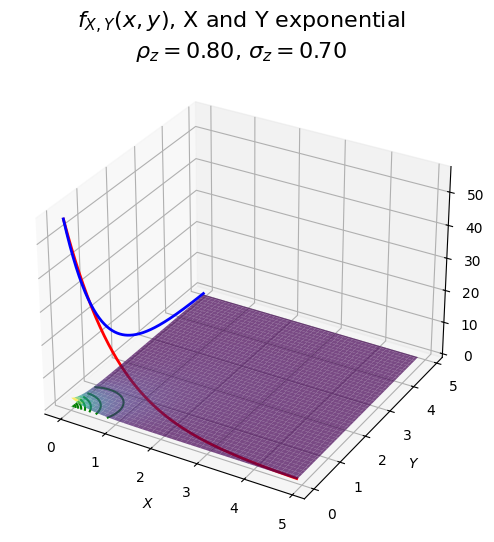

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Existing data
X, Y = np.meshgrid(xc, yc)  # Meshgrid from your xc and yc vectors
Z = pdf_theo  # Your already computed theoretical density

# Compute marginal densities
marginal_x = np.trapz(Z, axis=0)  # Integration over Y to get the marginal density of X
marginal_y = np.trapz(Z, axis=1)  # Integration over X to get the marginal density of Y

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Joint density surface
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)

# Marginal density of X on the X-Z plane
ax.plot(xc, np.zeros_like(xc), marginal_x, color='red', lw=2)

# Marginal density of Y on the Y-Z plane
ax.plot(np.zeros_like(yc), yc, marginal_y, color='blue', lw=2)

# Contour lines to illustrate density levels
ax.contour(X, Y, Z, zdir='z', offset=0, levels=10, colors='green')

# Axis labels in LaTeX
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.set_title(r'$f_{X,Y}(x,y)$' ", X and Y exponential" "\n" r'$\rho_z = %.2f$, $\sigma_z = %.2f$' % (rho, sigma), fontsize=16)

plt.show()


## Generation of Gamma correlated variables and Deriving the Joint PDF of Two Correlated Gamma Variables

we extend the results to the joint PDF of two correlated Gamma-distributed variables, obtained as sums of $k$ independent exponential variables.

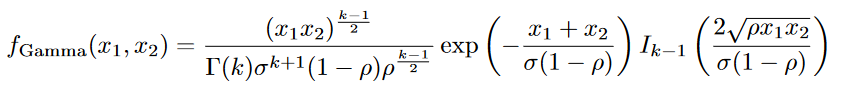

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv  # iv = I_v (Modified Bessel function of the first kind)
import math
def pdf_gamma_corr(x, y, Rho, Sigma, k):
    """
    Joint PDF of two correlated Gamma random variables (X, Y),
    using the provided formula and parameters.

    Parameters:
    x : float
        Value of X (must be > 0).
    y : float
        Value of Y (must be > 0).
    Rho : float
        Correlation coefficient of the intensity fields - = rho**2 for the complex fields (|rho| < 1).
    Sigma : float
        Sigma=2sigma**2, with sigma the standard deviation of the Gaussian fields.
    k : float
        Shape parameter of the Gamma distribution.

    Returns:
    float
        Value of the joint PDF at (x, y).
    """
    if x <= 0 or y <= 0:
        return 0.0
    # Denominator terms
    gamma_k = math.gamma(k)
    denom = gamma_k * (Sigma**(k+1)) * (1 - Rho)*Rho**((k - 1)/2)

    # Exponential term
    expo = np.exp(-(x + y) / (Sigma * (1 - Rho)))
    # Bessel function term (order k-1)
    arg_bessel = (2 * np.sqrt(Rho * x * y)) / (Sigma * (1 - Rho))
    bessel_val = iv(k - 1, arg_bessel)
    # Final PDF value
    pdf_value = ((x * y)**((k - 1) / 2)) / denom * expo * bessel_val
    return pdf_value


In [8]:
import numpy as np

# ----------------- Parameters -----------------
k = 12         # Shape parameter
N = 1000000    # Sample size
rho = 0.8      # Correlation coefficient
sigma = 1.2    # Standard deviation of the Gaussian field

# ----------------- Generate correlated Gaussian complex variables -----------------
# Generate two independent Gaussian variables
Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma)

X = np.zeros(N)
Y = np.zeros(N)

# ----------------- Compute intensities and sum over k samples -----------------


for _ in range(int(k)):
    Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma)
    X += np.abs(Zx)**2
    Y += np.abs(Zy)**2

# Now, X and Y are correlated Gamma variables with shape parameter k
# Change of variables
Rho=rho**2
Sigma=2*sigma**2



In [9]:
#Check that the correlation is rho**2, the mean is k Sigma
print('Empirical correlation',np.corrcoef(X, Y)[0,1], 'theoretical correlation',rho**2)
print("Mean of X:", np.mean(X), "Expected:", k * Sigma)
print("Empirical variance", np.var(X), "Theoretical variance:", k * Sigma**2)

from scipy.stats import gamma, kstest
# Ajuster une loi Gamma aux données X
shape, loc, scale = gamma.fit(X, floc=0)  # On fixe loc=0 pour Gamma
print(f"Fitted shape: {shape}, Fitted scale: {scale}")
# Comparer aux valeurs attendues
print(f"Expected shape: {k}, Expected scale: {Sigma}")
# Tester si X suit bien une loi Gamma(k, Sigma)
D, p_value = kstest(X, 'gamma', args=(k, 0, Sigma))
print(f"KS test statistic: {D}, p-value: {p_value}")

Empirical correlation 0.641616110554071 theoretical correlation 0.6400000000000001
Mean of X: 34.56860136919467 Expected: 34.56
Empirical variance 99.59102780409606 Theoretical variance: 99.5328
Fitted shape: 11.998430499989885, Fitted scale: 2.8810936038029147
Expected shape: 12, Expected scale: 2.88
KS test statistic: 0.0009462709552339188, p-value: 0.331879072593829


In [10]:
# Empirical 2D Histogram
bins = 280  # Number of bins for the histogram grid
# Define axis limits for the histogram (adjust based on data)
mean_X=k * Sigma
std_X=np.sqrt(k * Sigma**2)
# Définir un intervalle autour de la moyenne ± 4 écart-types
lower_bound = max(0, mean_X - 4 * std_X)
upper_bound = mean_X + 4 * std_X
range_xy = [[lower_bound, upper_bound], [lower_bound, upper_bound]]


# Compute 2D histogram with density normalization
H, xedges, yedges = np.histogram2d(X, Y, bins=bins, range=range_xy, density=True)
# Compute bin centers for plotting
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Dx = np.max(xc)-np.min(xc)
Dy = np.max(yc)-np.min(yc)
# ---------  Theoretical PDF Grid ---------
XX, YY = np.meshgrid(xc, yc, indexing='xy')  # Generate 2D grid (bins x bins)

pdf_theo = np.vectorize(pdf_gamma_corr)(XX, YY, Rho, Sigma, k)

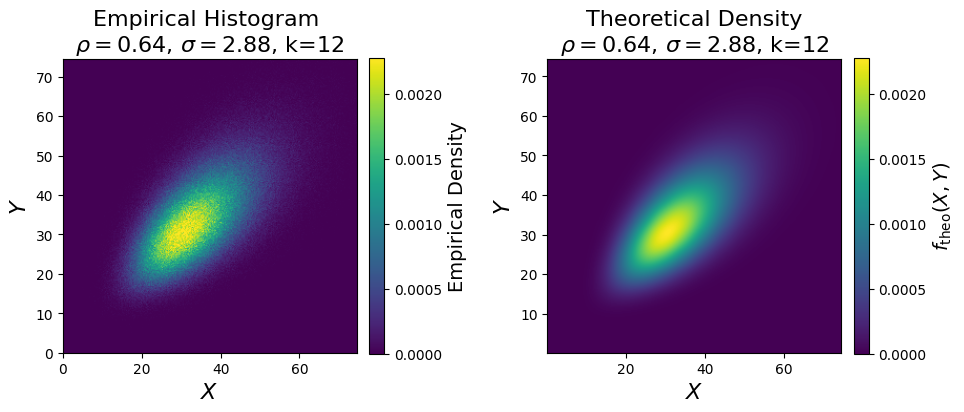

In [11]:
# ---------  Visualization and Comparison ---------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})  # Taille plus grande mais plots carrés

# A) Empirical: Heatmap of the histogram
im0 = axes[0].imshow(H.T, origin='lower',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='equal', cmap='viridis', vmin=0, vmax=np.max(pdf_theo))
axes[0].set_title(r"Empirical Histogram " "\n" r"$\rho = %.2f$, $\sigma = %.2f$, k=%d" % (Rho, Sigma,k), fontsize=16)
axes[0].set_xlabel(r"$X$", fontsize=16)
axes[0].set_ylabel(r"$Y$", fontsize=16)
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label(r"Empirical Density", fontsize=14)

# B) Theoretical: Heatmap of the analytical PDF
im1 = axes[1].imshow(pdf_theo.T, origin='lower',
                     extent=[xc[0], xc[-1], yc[0], yc[-1]],
                     aspect='equal', cmap='viridis', vmin=0, vmax=np.max(pdf_theo))
axes[1].set_title(r"Theoretical Density" "\n" r"$\rho = %.2f$, $\sigma = %.2f$, k=%d" % (Rho, Sigma,k), fontsize=16)
axes[1].set_xlabel(r"$X$", fontsize=16)
axes[1].set_ylabel(r"$Y$", fontsize=16)
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label(r"$f_{\text{theo}}(X, Y)$", fontsize=14)

plt.tight_layout(pad=2)
plt.show()

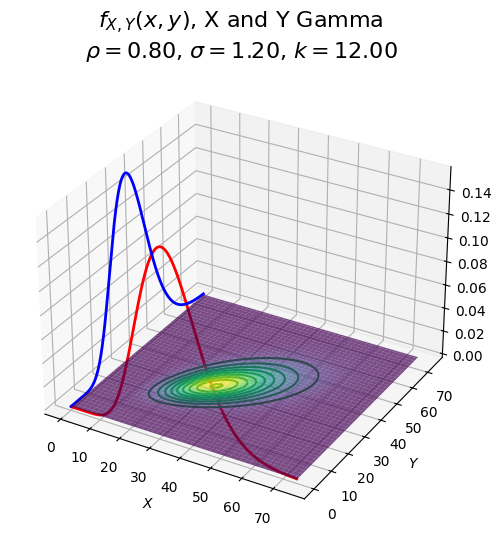

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Existing data
Xc, Yc = np.meshgrid(xc, yc)  # Meshgrid from your xc and yc vectors
Z = pdf_theo  # Your already computed theoretical density

# Compute marginal densities
marginal_x = np.trapz(Z, axis=0)  # Integration over Y to get the marginal density of X
marginal_y = np.trapz(Z, axis=1)  # Integration over X to get the marginal density of Y

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Joint density surface
ax.plot_surface(Xc, Yc, Z, cmap='viridis', edgecolor='none', alpha=0.7)

# Marginal density of X on the X-Z plane
ax.plot(xc, np.zeros_like(xc), marginal_x, color='red', lw=2)

# Marginal density of Y on the Y-Z plane
ax.plot(np.zeros_like(yc), yc, marginal_y, color='blue', lw=2)

# Contour lines to illustrate density levels
ax.contour(Xc, Yc, Z, zdir='z', offset=0, levels=10, colors='green')

# Axis labels in LaTeX
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.set_title(r'$f_{X,Y}(x,y)$' ", X and Y Gamma" "\n" r'$\rho = %.2f$, $\sigma = %.2f$, $k = %.2f$' % (rho, sigma,k), fontsize=16)
plt.show()

## Theoretical and Empirical Verification of the PDF of the Fujii Index

In this section, we aim to verify the probability density function (PDF) of the Fujii index, defined as:
D(X,Y)=

This PDF is derived analytically from the joint distribution of two correlated Gamma random variables XX and YY with identical shape parameter kk, scale parameter σσ, and correlation coefficient ρρ. The theoretical PDF $f_D(d)$ is expressed in closed form as:

$$\frac{(1 - \rho)^k (1 - r^2)^{k-1}}
{B(k,k) 2^{2k-2} (1 - \rho + \rho r^2)^{\frac{k+1}{2}}}$$

To validate our theoretical results, we will:



*   Compute the empirical PDF of D(X,Y) using histograms from the previously generated samples of X and Y

*   Implement the theoretical PDF formula for $D(X,Y)$

*   Compare both results graphically and numerically across different values of $k$, and $\rho$






In [13]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta  # Beta function from scipy.special

def pdf_ratio(r, rho, k):
    """
    Computes the theoretical PDF of the ratio X/Y.

    Parameters:
    r : float or ndarray
        Values at which to evaluate the PDF (0 <= r <= 1).
    rho : float
        Correlation coefficient of the Gamma variables X and Y.
    k : float
        Shape parameter of the Gamma distribution.

    Returns:
    float or ndarray
        The value of the PDF at r.
    """
    if np.any(r < 0):
        return 0.0

    # Compute the terms in the PDF formula
    numerator = ((1 - rho)**k)*(r**(k-1))*(r+1)
    denominator = float(beta(k, k)) * ((r+1)**2-4*rho*r)**(k+1/2)
    return numerator / denominator




In [14]:
# ----------------- Parameters -----------------
k = 5        # Shape parameter
N = 1000000    # Sample size
rho = 0.6      # Correlation coefficient
sigma = 1.2    # Standard deviation of the Gaussian field

# ----------------- Generate correlated Gaussian complex variables -----------------
# Generate two independent Gaussian variables
Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma)

X = np.zeros(N)
Y = np.zeros(N)

# ----------------- Compute intensities and sum over k samples -----------------


for _ in range(int(k)):
    Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma)
    X += np.abs(Zx)**2
    Y += np.abs(Zy)**2

# Now, X and Y are correlated Gamma variables with shape parameter k
# Change of variables
Rho=rho**2
Sigma=2*sigma**2



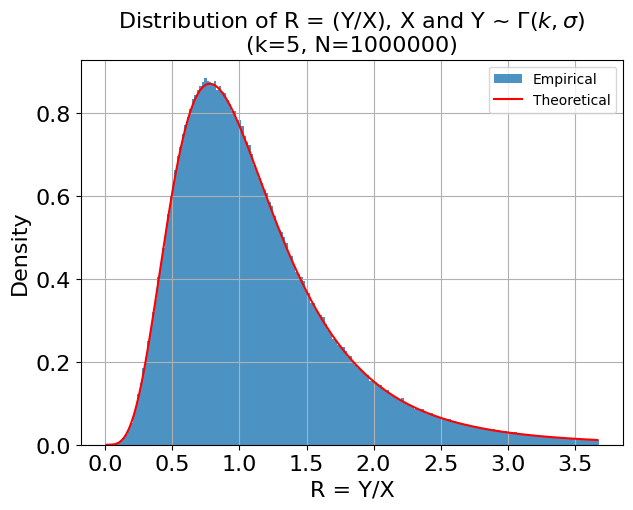

In [15]:
# Ratio R = X / Y
R = X/Y
rmax=np.percentile(R,99)
bins=200


# Compute histogram with density normalization
H, edges = np.histogram(R, bins=bins, range=(0, rmax), density=True)
bin_centers = 0.5 * (edges[:-1] + edges[1:])  # Compute bin centers for plotting
# Theoretical Values
# Calculate theoretical PDF values at bin centers
fb_vals = np.array([pdf_ratio(r, Rho, k) for r in bin_centers])


# Visualization
plt.figure(figsize=(7, 5))

# Plot empirical histogram
plt.hist(R, bins=bins, range=(0, rmax), density=True, alpha=0.8, label="Empirical")

# Plot theoretical PDF
plt.plot(bin_centers, fb_vals, 'r-', label="Theoretical")

# Titles and labels
plt.title(f"Distribution of R = (Y/X), X and Y ~ $\Gamma(k, \sigma)$ \n(k={k}, N={N})",fontsize=16)
plt.xlabel("R = Y/X",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

In [16]:


# --------- Theoretical PDF of D(X,Y) ---------
def pdf_fujii(r, rho, k):
    """
    Computes the theoretical PDF of the Fujii index D(X,Y) = |X - Y| / (X + Y).

    Parameters:
    r : float or ndarray
        Values at which to evaluate the PDF (0 <= r <= 1).
    rho : float
        Correlation coefficient of the Gamma variables X and Y.
    k : float
        Shape parameter of the Gamma distribution.

    Returns:
    float or ndarray
        The value of the PDF at r.
    """
    if np.any(r < 0) or np.any(r > 1):
        return 0.0

    # Compute the terms in the PDF formula
    numerator = (1 - rho)**k * (1 - r**2)**(k - 1)
    denominator = float(beta(k, k)) * 2**(2 * k - 2) * (1 - rho + rho * r**2)**(k+1/2)
    return numerator / denominator



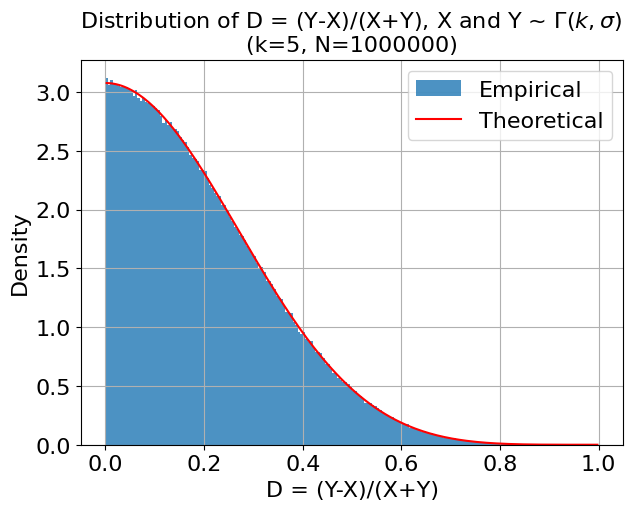

In [17]:
D = np.abs(X - Y) / (X + Y)
bins=200


# Compute histogram with density normalization
H, edges = np.histogram(D, bins=bins, range=(0, 1), density=True)
bin_centers = 0.5 * (edges[:-1] + edges[1:])  # Compute bin centers for plotting
# Theoretical Values
# Calculate theoretical PDF values at bin centers

fb_vals = np.array([pdf_fujii(r, Rho, k) for r in bin_centers])

# Visualization
plt.figure(figsize=(7, 5))

# Plot empirical histogram
plt.hist(D, bins=bins, range=(0, 1), density=True, alpha=0.8, label="Empirical")

# Plot theoretical PDF
plt.plot(bin_centers, fb_vals, 'r-', label="Theoretical")

# Titles and labels
plt.title(f"Distribution of D = (Y-X)/(X+Y), X and Y ~ $\Gamma(k, \sigma)$ \n(k={k}, N={N})",fontsize=16)
plt.xlabel("D = (Y-X)/(X+Y)",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend()
plt.legend(fontsize=16)
plt.show()

##  Theoretical and Empirical Verification of the Moments of the Fujii Index

In this section, we aim to verify the theoretical expressions of the moments of the Fujii index derived from our joint Gamma distribution model. We will focus on comparing three theoretical formulations of the mm-th order moments:



$$
\langle D^m \rangle =
\frac{B \left( \frac{m+1}{2}, k \right) (1 - \rho)^{-\frac{1}{2}}}
{B(k,k) 2^{2k-1}}
F \left( k + \frac{1}{2}, \frac{m+1}{2} ; \frac{m+1}{2} + k ;
- \frac{\rho}{1 - \rho} \right)
$$

$$
\langle D^m \rangle =
\frac{B \left( \frac{m+1}{2}, k \right) (1 - \rho)^{\frac{m}{2}}}
{B(k,k) 2^{2k-1}}
F \left( \frac{m}{2}, \frac{m+1}{2} ; \frac{m+1}{2} + k ; \rho \right)
$$

$$\langle D^m \rangle =
\frac{B \left( \frac{m+1}{2}, k \right) (1 - \rho)^k}
{B(k,k) 2^{2k-1}}
F \left( k, k + \frac{1}{2}, k + \frac{m+1}{2} ; \rho \right)$$

To ensure the correctness and robustness of our theoretical results, we will:



*   Compute the moments empirically from the previously generated correlated Gamma samples X and Y.
*   Implement both theoretical formulas for $\langle D^m \rangle$.
*   Compare the empirical moments with both theoretical formulations across various parameters $k$ (shape parameter), $\rho$ (correlation coefficient), and $m$ (moment order)



In [18]:
import scipy.special as sp
import numpy as np

def moment_dm(m, k, Rho):
    """
    Compute moment <r^m> in terms of de m, k and Rho=rho**2.

    Parameters:
        m (float): moment order
        k (float): Gamma Distribution shape parameter.
        Rho (float): correlation between X and Y

    Returns:
        float: value of moment <r^m>.
    """
    # Beta function B(a, b)
    B_m_k = sp.beta((m + 1) / 2, k)
    B_k_k = sp.beta(k, k)

    # Moment computation
    moment_v1 = (B_m_k * (1 - Rho)**(-1/2)) / (2**(2 * k - 1) * B_k_k) * sp.hyp2f1(k+1/2, (m + 1) / 2, (m + 1) / 2 + k, -Rho/(1-Rho))
    moment_v2 = (B_m_k * (1 - Rho)**(m / 2)) / (2**(2 * k - 1) * B_k_k) * sp.hyp2f1(m / 2, (m + 1) / 2, (m + 1) / 2 + k, Rho)
    moment_v3 = (B_m_k * (1 - Rho)**(k)) / (2**(2 * k - 1) * B_k_k) * sp.hyp2f1(k, k+1/2, (m + 1) / 2 + k, Rho)

    return moment_v1,moment_v2,moment_v3



In [19]:
# test Empirical formula and theoretical formula

# ----------------- Parameters -----------------
k = 5        # Shape parameter
N = 1000000    # Sample size
rho = 0.6      # Correlation coefficient
sigma = 1.2    # Standard deviation of the Gaussian field

# ----------------- Generate correlated Gaussian complex variables -----------------
# Generate two independent Gaussian variables
Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma)
X = np.zeros(N)
Y = np.zeros(N)

# ----------------- Compute intensities and sum over k samples -----------------


for _ in range(int(k)):
    Zx, Zy = generate_correlated_complex(N, rho=rho, sigma=sigma)
    X += np.abs(Zx)**2
    Y += np.abs(Zy)**2

# Now, X and Y are correlated Gamma variables with shape parameter k
# Change of variables
Rho=rho**2
Sigma=2*sigma**2

D=np.abs(X-Y)/(X+Y)


m1=moment_dm(1, k, Rho)
m2=moment_dm(2, k, Rho)
m3=moment_dm(3, k, Rho)


print(f"{'Empirical Moments:':<30} First Order: {np.mean(R**1):<10.6f} | Second Order: {np.mean(R**2):<10.6f} | Third Order: {np.mean(R**3):<10.6f}\n")
print(f"{'First formulation:':<30} First Order: {m1[0]:<10.6f} | Second Order: {m2[0]:<10.6f} | Third Order: {m3[0]:<10.6f}")
print(f"{'Second formulation:':<30} First Order: {m1[1]:<10.6f} | Second Order: {m2[1]:<10.6f} | Third Order: {m3[1]:<10.6f}")
print(f"{'Third formulation:':<30} First Order: {m1[2]:<10.6f} | Second Order: {m2[2]:<10.6f} | Third Order: {m3[2]:<10.6f}")


Empirical Moments:             First Order: 1.160568   | Second Order: 1.851100   | Third Order: 4.530199  

First formulation:             First Order: 0.203297   | Second Order: 0.063700   | Third Order: 0.024915  
Second formulation:            First Order: 0.203297   | Second Order: 0.063700   | Third Order: 0.024915  
Third formulation:             First Order: 0.203297   | Second Order: 0.063700   | Third Order: 0.024915  


## Particular cases

### First Order moments

In [20]:
rhos = np.linspace(0.001, 0.9999, 100)

resultk1 = moment_dm(1, 1, rhos)
resultk2 = moment_dm(1, 2, rhos)
resultk3 = moment_dm(1, 3, rhos)
resultk4 = moment_dm(1, 4, rhos)
resultk10 = moment_dm(1, 10, rhos)


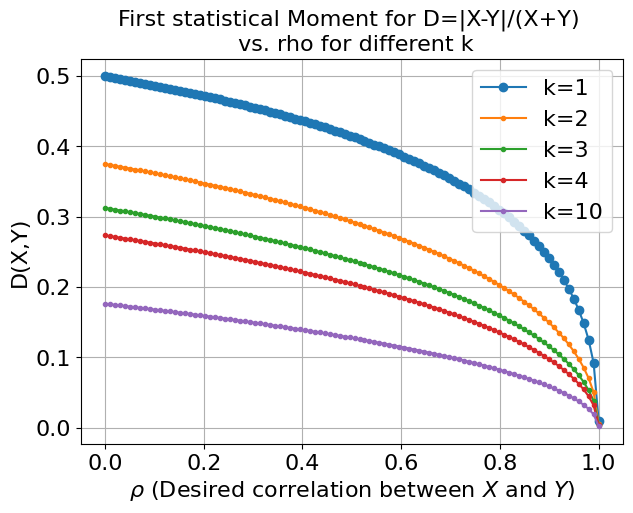

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
# Plot empirical Fujii mean values
plt.plot(rhos, resultk1[1], 'o-', label='k=1')
plt.plot(rhos, resultk2[1], '.-', label='k=2')
plt.plot(rhos, resultk3[1], '.-', label='k=3')
plt.plot(rhos, resultk4[1], '.-', label='k=4')
plt.plot(rhos, resultk10[1], '.-', label='k=10')

# Labels and titles
plt.xlabel(r"$\rho$ (Desired correlation between $X$ and $Y$)", fontsize=16)
plt.ylabel("D(X,Y)", fontsize=16)
plt.title("First statistical Moment for D=|X-Y|/(X+Y) \n vs. rho for different k", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend()
plt.legend(fontsize=16)
plt.show()
plt.show()

### Particular Case : Exponential Variables k=1

In [22]:
rhos = np.linspace(0.1, 0.9999, 100)
resultk1 = moment_dm(1, 1, rhos)[0]
resultk2 = moment_dm(2, 1, rhos)[0]
stdk = np.sqrt(resultk2-resultk1**2)


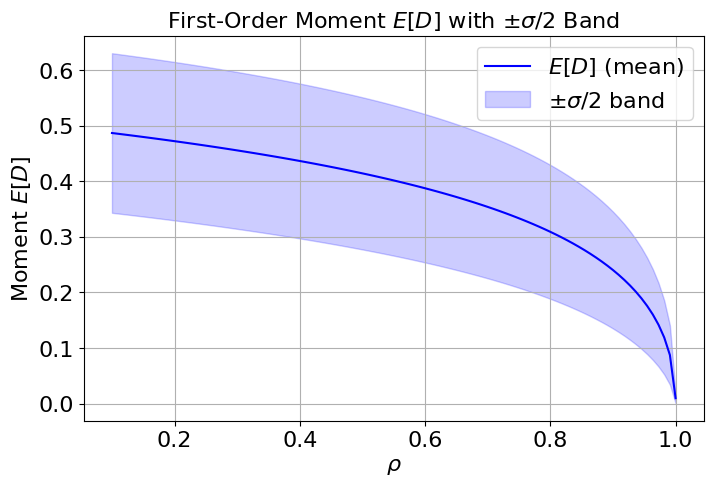

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(rhos, resultk1, label=r'$E[D]$ (mean)', color='blue')
plt.fill_between(rhos, resultk1 - stdk/2, resultk1 + stdk/2, color='blue', alpha=0.2, label=r'$\pm \sigma$/2 band')
plt.xlabel(r'$\rho$', fontsize=16)
plt.ylabel(r'Moment $E[D]$', fontsize=16)
plt.title('First-Order Moment $E[D]$ with $\pm \sigma $/2 Band', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### Particular case: $\rho=0$

In [24]:
ks = np.linspace(1, 50, 100)
resultm1 = moment_dm(1, ks, 0)
resultm2 = moment_dm(2, ks, 0)
resultm3 = moment_dm(3, ks, 0)
resultm4 = moment_dm(4, ks, 0)


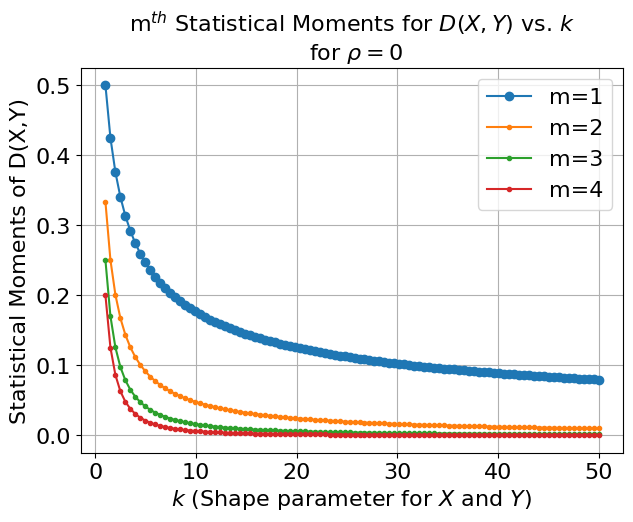

In [25]:
plt.figure(figsize=(7, 5))
# Plot empirical Fujii mean values
plt.plot(ks, resultm1[1], 'o-', label='m=1')
plt.plot(ks, resultm2[1], '.-', label='m=2')
plt.plot(ks, resultm3[1], '.-', label='m=3')
plt.plot(ks, resultm4[1], '.-', label='m=4')

# Labels and titles
plt.xlabel("$k$ (Shape parameter for $X$ and $Y$)", fontsize=16)
plt.ylabel("Statistical Moments of D(X,Y)", fontsize=16)
plt.title(r"m$^{th}$ Statistical Moments for $D(X,Y)$ vs. $k$ " "\n" r" for $\rho=0$", fontsize=16)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend()
plt.legend(fontsize=16)
plt.show()
plt.show()